## Лабораторная 5: логистическая регрессия. ROC. AUC. One-hot encoding

## 1
Рассмотрим данные медицинской страховой фирмы. На основе характеристик пациентов `Members.csv` (возраст, пол) и данных о получении медицинского обслуживания в предыдущем году `Claims_Y1.csv` (медицинское учреждение, врач, тип проблемы, количество дней госпитализации, дата, и др. ) нужно предсказать факт госпитализации хотя бы на 1 день в следующем году `DaysInHospital_Y2.csv`.

In [80]:
import pandas as pd

from sklearn import *

%matplotlib inline
import matplotlib.pyplot as plt

Прочтите данные, в качестве параметра index_col используйте `MemberID`. 

* данные из таблицы 'DaysInHospital_Y2.csv' в переменную `days2`
* данные из таблицы 'Members.csv' в переменную `m`
* данные из таблицы 'Claims_Y1.csv' в переменную `claims`

In [81]:
days2 = pd.read_csv(r'C:\Users\user\Desktop\Машинное обучение\lab5\DaysInHospital_Y2.csv', index_col = (['MemberID']))
m = pd.read_csv(r'C:\Users\user\Desktop\Машинное обучение\lab5\Members.csv', index_col = (['MemberID']))
claims = pd.read_csv(r'C:\Users\user\Desktop\Машинное обучение\lab5\Claims_Y1.csv', index_col = (['MemberID']))

## 2
Чтобы анонимизировать данные организатор указал приблизительную информацию о пациентах, например в столбце возраст указаны возрастные группы: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. Преобразуем строковые признаки в количественные и заменим пропущенные значения:

In [82]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: s.split('-')[0] if s!='80+' else '80')
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s))

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

m.Sex = m.Sex.fillna(value='N')

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

## 3
Сконструируем признаки по массиву случаев медицинского обслуживания: 
* `f_Charlson` — максимальный индекс коморбидности Чальсона по всем случаям для пациента (`CharlsonIndex` в таблице `claims`)
* `f_LengthOfStay` — суммарное количество дней госпитализации в прошлом году (`LengthOfStay` в таблице `claims`) 

*Функции, которые могут пригодиться при решении: `.groupby(['MemberID']), .max(), .sum()`* 

In [83]:
f_Charlson = claims['CharlsonIndex'].groupby(['MemberID']).max()
f_LengthOfStay = claims['LengthOfStay'].groupby(['MemberID']).sum()

## 4

Составим матрицу объектов признаков со столбцами: `f_Charlson`, `f_LengthOfStay`, возраст пациента, `ClaimsTruncated` (не оказалось ли случаев медицинского обслуживания слишком много):

*Функции, которые могут пригодиться при решении: `.join()`*

In [84]:
data = days2
data = data.join(f_Charlson).join(f_LengthOfStay)

# место для кода
data.head(5)

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay
MemberID,,,,
98324177,0,0,0,0
33899367,1,1,0,0
5481382,0,1,0,0
69908334,0,0,0,0
29951458,0,0,0,0


## 5
Составим функцию, которая будет делить выборку на две части `dataTrain` и `dataTest`, обучать логистическую регрессию на `dataTrain`, применять к `dataTest`, строить кривую ошибок и считать под ней площадь:

In [85]:
def calcAUC(data):
    dataTrain, dataTest = model_selection.train_test_split(data, test_size=0.5, random_state=1)
    model = linear_model.LogisticRegression()
    model.fit( dataTrain.loc[:, dataTrain.columns != 'DaysInHospital'], dataTrain.DaysInHospital )
    predictionProb = model.predict_proba( dataTest.loc[:, dataTest.columns != 'DaysInHospital'] )
    fpr, tpr, _ = metrics.roc_curve(dataTest['DaysInHospital'], predictionProb[:,1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()
    print( metrics.roc_auc_score(dataTest['DaysInHospital'], predictionProb[:,1]) )

## 6
Применим данную функцию к `data`:

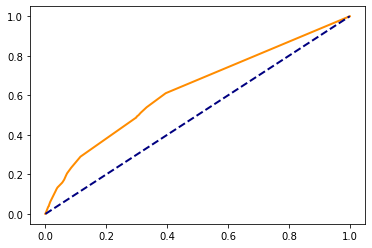

0.6307469087049324


In [86]:
calcAUC(data)

## 7
Логистическая регрессия принимает на вход только количественные признаки.

Добавим к нашим данным пол пациента, применив one hot encoding:

*Функции, которые могут пригодиться при решении: `pd.get_dummies(m.Sex, prefix='pol')`* 

In [87]:
pd.get_dummies(m.Sex, prefix='pol')
data = data.join(pd.get_dummies(m.Sex, prefix='pol'))

## 8
Попытайтесь применить  one hot encoding к уже существующим в `data2` признакам или составить новые признаки по массиву `claims`.

In [88]:
data2 = data
data2 = data2.join(pd.get_dummies(claims.Year, prefix='f_Charlson'))
data2

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,pol_F,pol_M,pol_N,f_Charlson_Y1
MemberID,,,,,,,,
210,0,0,0,2,0,0,1,1
210,0,0,0,2,0,0,1,1
210,0,0,0,2,0,0,1,1
210,0,0,0,2,0,0,1,1
210,0,0,0,2,0,0,1,1
...,...,...,...,...,...,...,...,...
99998627,0,0,1,2,1,0,0,1
99998627,0,0,1,2,1,0,0,1
99998627,0,0,1,2,1,0,0,1


Построившему матрицу объектов признаков, для которой логистическая регрессия работает с наилучшим качеством: +5 бонусных баллов.